In [1]:
import numpy as np
import pandas as pd
import io
import statsmodels.formula.api as smf
import scipy.stats as stats
import scipy
import seaborn as sns
import re
import matplotlib.pyplot as plt


Исследуем датасет, посвященные сердечным приступам. 

## Для полного анализа необходимо:
1. Построенить OLS-модель и график
2. Интерпретировать коэффициенты модели 
3. Вычисленить предсказанные значения, TSS, RSS, ESS, стандартную ошибку, R^2 и R^2adj.
4. Проанализировать значимость переменных 
5. Провести F-test
6. Вычислить Доверительные интервалы
7. Составить прогнорз для отдельных людей 
8. Вычислить коэффициенты VIF
9. Провести анализ структурных сдвигов
10. Спецификация
11. Провести BP-тест 
12. Провести тест Дарбина-Уотсона


## 1. OLS-модель, график

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/vysotinavaleria/Homework-econometrics/main/heart.csv')
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


#### Регрессия
$$
Thalachh (пульс) = \beta_0 + \beta_1*age +\beta_2*sex+\beta_3*trtbps (давление)
$$

In [4]:
heart_eq = smf.ols(formula='thalachh~age+sex+trtbps', data=df).fit()
heart_eq.params.round(3)

Intercept    199.136
age           -1.073
sex           -4.034
trtbps         0.088
dtype: float64

<AxesSubplot: xlabel='age', ylabel='trtbps'>

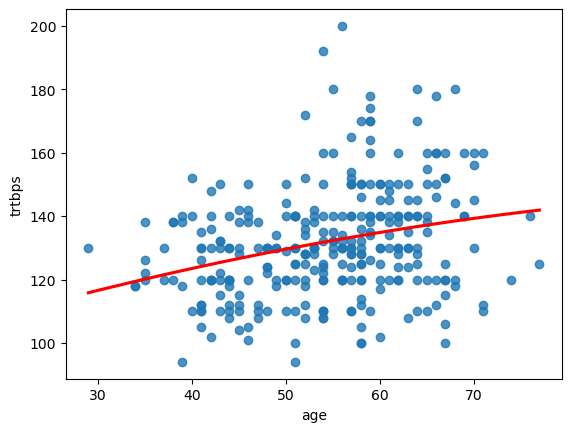

In [5]:
sns.regplot(data=df, y='trtbps', x='age', ci=None, order = 2, line_kws={"color": "r"})

### Интерпретация графика
У возраста и артериального давления наблюдается прямая зависимость, чем старше человек, тем выше его давление.

## 2. Интерпретация коэффициентов модели

- При увеличении возраста человека на 1 год, пулье снижается на 1.073 при прочих равных условиях
- У мужчин пульс выше на 4.034 удара в минуту при прочих равных условиях 
- При повышении артериального давления на 1, пульс  увеличивается на 0.088 при прочих равных условиях.

## 3. Вычисление предсказанных значений, TSS, RSS, ESS, стандартной ошибки, R^2 и R^2adj.

In [7]:
TSS = heart_eq.centered_tss.round(3)
ESS = heart_eq.ess.round(3)
RSS = heart_eq.ssr.round(3)
R2 = RSS/TSS
s2 = RSS/(303 - 3)
R2adj = 1 - (1 - R2)*(303-1)/(303 - 3)

In [8]:
print('TSS= ', TSS)
print('ESS= ', ESS)
print('RSS= ', RSS)
print('R2 (коэффициент детерминации) = ', R2)
print('s2 (стандартная ошибка) = ', s2)
print('R2agj (исправленный коэффициент детерминации)= ', R2adj)

TSS=  158443.215
ESS=  26937.681
RSS=  131505.534
R2 (коэффициент детерминации) =  0.8299852663302749
s2 (стандартная ошибка) =  438.35178
R2agj (исправленный коэффициент детерминации)=  0.8288518347724767


## 4. Анализ значимости переменных регрессии

In [9]:
model = smf.ols(formula='thalachh~age+sex+trtbps', data=df).fit()
model.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,199.1356,10.713,18.588,0.000,178.053,220.218
age,-1.0730,0.139,-7.725,0.000,-1.346,-0.800
sex,-4.0340,2.603,-1.549,0.122,-9.158,1.089
trtbps,0.0881,0.072,1.229,0.220,-0.053,0.229


In [10]:
df = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0] 
df

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,199.1356,10.713,18.588,0.000,178.053,220.218
age,-1.0730,0.139,-7.725,0.000,-1.346,-0.800
sex,-4.0340,2.603,-1.549,0.122,-9.158,1.089
trtbps,0.0881,0.072,1.229,0.220,-0.053,0.229


In [11]:
df['tvalues']  = df['coef']/df['std err']
df

,coef,std err,t,P>|t|,[0.025,0.975],tvalues
Intercept,199.1356,10.713,18.588,0.000,178.053,220.218,18.588220
age,-1.0730,0.139,-7.725,0.000,-1.346,-0.800,-7.719424
sex,-4.0340,2.603,-1.549,0.122,-9.158,1.089,-1.549750
trtbps,0.0881,0.072,1.229,0.220,-0.053,0.229,1.223611


In [12]:
alpha = 0.05 
print('Уровень значимости alpha: ', alpha)
DF = int(model.df_resid) 
t_crit = scipy.stats.t.ppf(1-alpha/2, DF)
print('Критическое значение t_crit: ', t_crit.round(3))

Уровень значимости alpha:  0.05
Критическое значение t_crit:  1.968


In [13]:
df['znachimosty'] = df.apply(lambda x : 'znachim' if np.abs(x['tvalues']) > t_crit else 'ne znachim', axis = 1 )
df

,coef,std err,t,P>|t|,[0.025,0.975],tvalues,znachimosty
Intercept,199.1356,10.713,18.588,0.000,178.053,220.218,18.588220,znachim
age,-1.0730,0.139,-7.725,0.000,-1.346,-0.800,-7.719424,znachim
sex,-4.0340,2.603,-1.549,0.122,-9.158,1.089,-1.549750,ne znachim
trtbps,0.0881,0.072,1.229,0.220,-0.053,0.229,1.223611,ne znachim


### Вывод
При анализе пульса у пациентов значимым показателем является только  возраст, в то время как пол и давление не значимы.

## 5. F-test

$$
H0: \beta_{thalachh}=\beta_{age}=\beta_{sex}=\beta_{trtbps}=0
$$
$$
H1: \beta_{thalachh}^2+\beta_{age}^2+\beta_{sex}^2+\beta_{trtbps}^2>0
$$

In [30]:
# Отфильтруем датафрейм по половому признаку
heart_w = df[df['sex']==1] # Датафрейм для женщин
heart_m = df[df['sex']==0] # Датафрейм для мужчин

In [31]:
heart_m

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
11,48,0,2,130,275,0,1,139,0,0.2,2,0,2,1
14,58,0,3,150,283,1,0,162,0,1.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0
292,58,0,0,170,225,1,0,146,1,2.8,1,2,1,0
296,63,0,0,124,197,0,1,136,1,0.0,1,0,2,0
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0


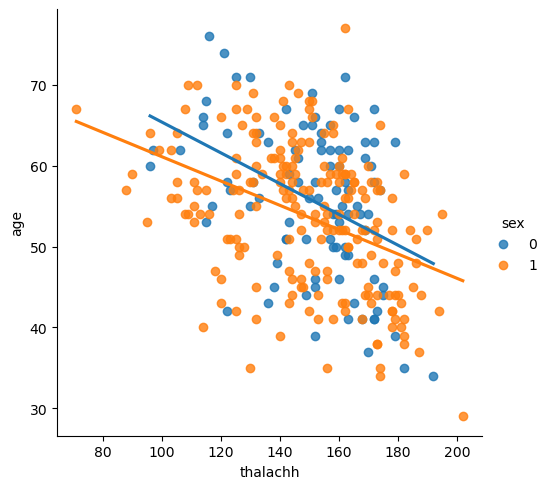

In [33]:
sns.lmplot(data = df, x = 'thalachh', y = 'age', ci = None, hue = 'sex')

In [35]:
hrt = smf.ols(data= df, formula='thalachh~age+sex+trtbps').fit()
hrt_w = smf.ols(data=heart_w , formula='thalachh~age+sex+trtbps').fit()
hrt_m = smf.ols(data= heart_m, formula='thalachh~age+sex+trtbps').fit()

In [36]:
print(f'RSS:{hrt.ssr.round(2)}, RSS_1:{hrt_w.ssr.round(2)},RSS_2:{hrt_m.ssr.round(2)} ')

RSS:131505.53, RSS_1:99117.77,RSS_2:31890.3 


In [38]:
F_obs =( hrt.ssr - (hrt_w.ssr + hrt_m.ssr) )/((hrt_w.ssr + hrt_m.ssr)) * (len( heart_w ) + len( heart_m) - 14) / 4
F_obs

0.27434831968523354

In [39]:
alpha = 0.05
stats.f.ppf(1-alpha,4,len( heart_m ) + len( heart_w) - 14  )

2.4028824503558126

Вывод:
$$
F_{obs}<F_{cr}
$$
Данные согласуются с гипотезой Н0, структурные изменения не значимы

## 6. Доверительные интервалы

In [40]:
model1 = smf.ols(formula='thalachh~age+sex+trtbps', data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               thalachh   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     20.42
Date:                Sat, 13 May 2023   Prob (F-statistic):           4.61e-12
Time:                        15:13:45   Log-Likelihood:                -1350.0
No. Observations:                 303   AIC:                             2708.
Df Residuals:                     299   BIC:                             2723.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    199.1356     10.713     18.588      0.000     178.053     220.218
age           -1.0730      0.139     -7.725      0.000      -1.346      -0.800
sex           -4.0340      2.603     -1.549      0.122      -9.158       1.089
trtbps         0.0881      0.072      1.229      0.220      -0.053       0.229
==============================================================================
Omnibus:                       17.944   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.104
Skew:                          -0.628   Prob(JB):                     4.31e-05
Kurtosis:                       2.879   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
df_table = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
df_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,199.1356,10.713,18.588,0.000,178.053,220.218
age,-1.0730,0.139,-7.725,0.000,-1.346,-0.800
sex,-4.0340,2.603,-1.549,0.122,-9.158,1.089
trtbps,0.0881,0.072,1.229,0.220,-0.053,0.229


In [42]:
alpha = 0.05 # Уровень значимости 5%
nobs = model.nobs
regr_cnt = model.df_model + 1
print(f'Количество наблюдений = {nobs:.0f}')
print(f'Количество регрессоров + 1 = {regr_cnt:.0f}')
# 5%-критическое значение t-распределения
t_cr = stats.t.ppf(1-alpha/2, nobs - regr_cnt)
print(f'Уровень значимости alpha = {alpha:.2f}')
print(f'Критическое значение t_cr = {t_cr:.3f}')

Количество наблюдений = 303
Количество регрессоров + 1 = 4
Уровень значимости alpha = 0.05
Критическое значение t_cr = 1.968


In [43]:
df_table['lower'] = (df_table['coef'].astype(float) - df_table['std err'].astype(float)*t_cr).round(2)
df_table['upper'] = (df_table['coef'].astype(float) + df_table['std err'].astype(float)*t_cr).round(2)
df_table

,coef,std err,t,P>|t|,[0.025,0.975],lower,upper
Intercept,199.1356,10.713,18.588,0.000,178.053,220.218,178.05,220.22
age,-1.0730,0.139,-7.725,0.000,-1.346,-0.800,-1.35,-0.80
sex,-4.0340,2.603,-1.549,0.122,-9.158,1.089,-9.16,1.09
trtbps,0.0881,0.072,1.229,0.220,-0.053,0.229,-0.05,0.23


## 7. Построение прогноза

In [45]:
df1 = df.head(4)
df1

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1


In [46]:
res = model.predict(exog=df1, transform=True)

In [47]:
df_res = pd.DataFrame(res.round(2), columns=['Прогноз'])
df_res.reset_index(drop=True , inplace=True)
df_res.index += 1
df_res

,Прогноз
1,140.28
2,166.86
3,166.60
4,145.59


#### Таким образом, мы получили прогноз для первых четырех людей 

## 8. Вычисление коэффициенты VIF

In [57]:
model_0 = smf.ols(data = df , formula = 'thalachh~age+sex+trtbps').fit()
model_1 = smf.ols(data = df , formula = 'age~sex+trtbps+thalachh').fit()
model_2 = smf.ols(data = df , formula = 'sex~age+thalachh+trtbps').fit()
model_3 = smf.ols(data = df , formula = 'trtbps~age+sex+thalachh').fit()
model_1.params.round(3)

Intercept    61.512
sex          -1.972
trtbps        0.132
thalachh     -0.155
dtype: float64

In [58]:
model_2.params.round(3)

Intercept    1.429
age         -0.007
thalachh    -0.002
trtbps      -0.001
dtype: float64

In [59]:
model_3.params.round(3)

Intercept    91.478
age           0.592
sex          -0.876
thalachh      0.057
dtype: float64

In [60]:
model_0.params

Intercept    199.135622
age           -1.073006
sex           -4.034019
trtbps         0.088149
dtype: float64

In [61]:
model.rsquared

0.17001473301230074

In [62]:
VIF_1 = 1/(1 - model_1.rsquared.round(3))
VIF_1.round(3)

1.311

In [63]:
VIF_2 = 1/(1 - model_2.rsquared.round(3))
VIF_2.round(3)

1.019

In [64]:
VIF_3 = 1/(1 - model_3.rsquared.round(3))
VIF_3.round(3)

1.092

## 9. Анализ структурных сдвигов

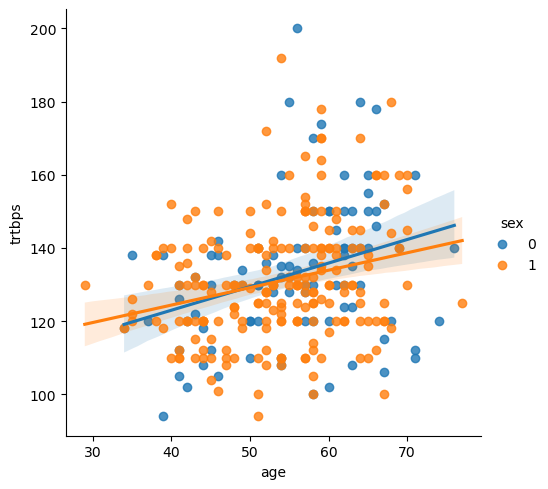

In [65]:
sns.lmplot(x='age', y='trtbps', hue='sex', data=df)

### Анализ графика:
В раннем возрасте артериальное давление больше у женнщин, а начинеая с 55 лет - у мужчин.

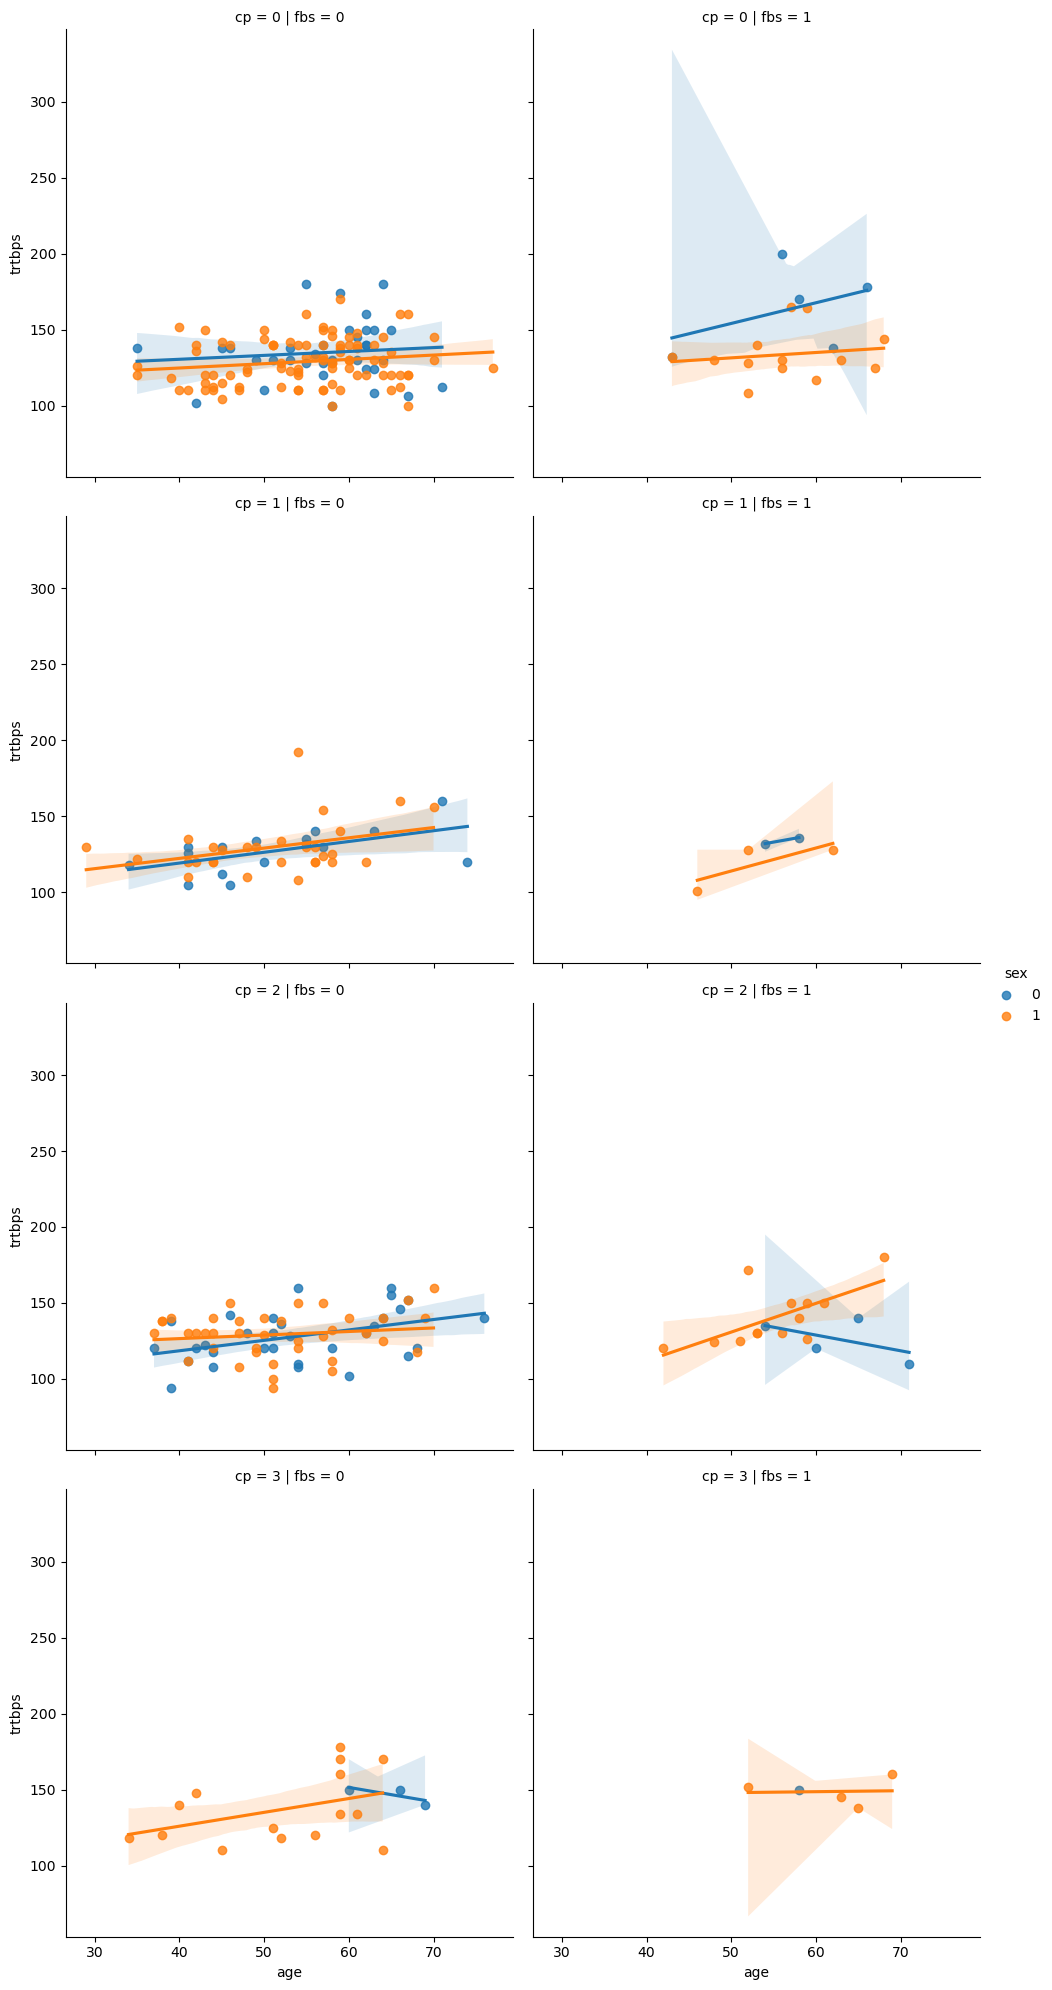

In [67]:
sns.lmplot(x="age", y="trtbps",hue='sex', row="cp",col='fbs', data=df)

### Анализ графиков:
- Артериальное давление у людей с болью в груди примерно одинаковое вне зависимости о пола
- У мужчин сильная боль в груди и повышенный сахар встречается чаще, чем у женщин
- Большинство людей не испытывают боли в груди и не страдают сахарным диабетом
- Давление у каждой из групп примерно одинаковое

## 10. Reset-test

In [68]:
model = smf.ols(formula='thalachh~age+sex+trtbps', data=df).fit()
model.params

Intercept    199.135622
age           -1.073006
sex           -4.034019
trtbps         0.088149
dtype: float64

In [69]:
df['tha2'] =model.predict()**2
df['tha3'] =model.predict()**3
df['tha4'] =model.predict()**4

In [71]:
model_1 = smf.ols(formula='thalachh~age+sex+trtbps+tha2+tha3+tha4', data=df).fit()
model.params

Intercept    199.135622
age           -1.073006
sex           -4.034019
trtbps         0.088149
dtype: float64

In [72]:
R2=model_1.rsquared
R2_res = model.rsquared

In [73]:
((R2 - R2_res)/(1-R2))*((len(df)-7)/3)

1.2176033155366943

In [74]:
alpha = 0.05
stats.f.ppf(1-alpha,3,len(df)-7).round(2)

2.64

$$
H0: \beta_{thalachh}=\beta_{age}=\beta_{sex}=\beta_{trtbps}=0
$$
$$
H1: \beta_{thalachh}^2+\beta_{age}^2+\beta_{sex}^2+\beta_{trtbps}^2>0
$$
$$
F_{obs}<F_{cr}
$$
Данные согласуются с гипотезой Н0

## 11. BP-тест

In [75]:
df['res2']=model.resid**2
df['res']=model.resid

In [76]:
sub_model= smf.ols(data=df, formula='res2~age+sex+trtbps+tha2+tha3+tha4').fit()

In [77]:
St = np.round(len(df)*sub_model.rsquared,2)
St

9.84

In [78]:
Hi2 = stats.chi2.ppf(1-0.05,6)
Hi2

12.591587243743977

$$ 
nR_0^2<X_p^2
$$
Тест указывает на гомоскедастичность, нет оснований отвергать гипотезу Н0

## 12. Тест Дарбина-Уотсона

In [79]:
resSq = sum(model.resid**2)

In [80]:
sum_resid = 0
for i in range(len(model.resid)-1):
    sum_resid+=(model.resid[i+1]-model.resid[i])**2

In [81]:
sum_resid/resSq

1.7791025762185397

$$
p≠0
$$
Присутствует серийная корреляция